In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Environment Setup

In [ ]:
import os
%cd '/content/drive/Shareddrives/Workspace/LoFiMIDI/'
BASE_PATH = '/content/drive/Shareddrives/Workspace/LoFiMIDI/'
def getFile(x):
  path = os.path.join(BASE_PATH,x)
  if os.path.exists(path):
    return path
  raise FileNotFoundError

/content/drive/Shareddrives/Workspace/LoFiMIDI


In [ ]:
! sudo apt install  -q -y fluidsynth
! pip install -q mir_eval
! pip install -q pretty_midi #เพื่อสร้างและแยกวิเคราะห์ไฟล์ MIDI
! pip install -q --upgrade pyfluidsynth #สำหรับสร้างการเล่นเสียงใน Colab

Reading package lists...
Building dependency tree...
Reading state information...
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import IPython

from mir_eval import display as dpy
from librosa import display as dp
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Data Exploration

In [ ]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll ใช้ฟังก์ชัน specshow ของ librosa ในการแสดงเปียโนโรล
    dp.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [ ]:
midi_data = pretty_midi.PrettyMIDI(getFile('/content/drive/Shareddrives/Workspace/LoFiMIDI/Classical/Mozart/mz_311_1_format0.mid'))

(array([  0.        ,   0.3       ,   1.2375    ,   4.3486115 ,
         4.7595705 ,   5.1543075 ,   5.585962  ,   8.121172  ,
         8.5559545 ,   8.9697475 ,   9.3697475 ,  10.2652695 ,
        11.9918875 ,  12.411468  ,  12.8141525 ,  13.230819  ,
        16.188564  ,  16.56787425,  17.00120758,  17.40937108,
        17.78911808,  18.18385508,  18.57346558,  18.95563108,
        19.34272808,  19.74541258,  20.13250958,  20.50750958,
        22.86045158,  23.27424458,  23.67965008,  24.07700108,
        24.48516458,  24.87226158,  25.26441858,  25.64903408,
        26.82550508,  28.77355758,  29.72593858,  30.42361308,
        30.86805758,  31.26021458,  31.81577008,  34.48243708,
        34.89339608,  35.28813308,  35.71978758,  36.56485758,
        38.20869358,  38.64347608,  39.05726908,  39.52601908,
        42.06122908,  42.47218808,  42.86692508,  43.29857958,
        45.83378958,  46.26857208,  46.68236508,  47.15480608,
        48.08503908,  49.77517908,  50.18613808,  50.5

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


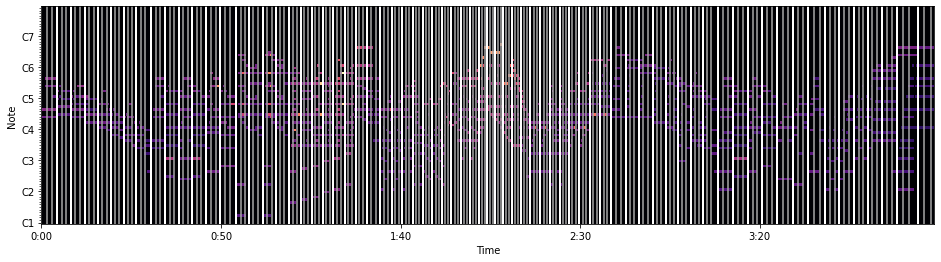

In [ ]:
# Get and downbeat times
beats = midi_data.get_beats()
downbeats = midi_data.get_downbeats()
print(midi_data.get_tempo_changes())
# Plot piano roll
plt.figure(figsize=(16,4))
plot_piano_roll(midi_data, 24, 108)
ymin, ymax = plt.ylim()
dpy.events(beats, base=ymin, height=ymax, color='#AAAAAA')
dpy.events(downbeats, base=ymin, height=ymax, color='#FFFFFF', lw=2)

In [ ]:
IPython.display.Audio(midi_data.synthesize(fs=16000), rate=16000)

In [ ]:
midi_data.get_piano_roll().shape

(128, 24863)

In [ ]:
print('Number of instruments:', len(midi_data.instruments)) #จำนวนเครื่องดนตรี
for instrument in midi_data.instruments:
  instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
  print('Instrument name:', instrument_name) #ชื่อเครื่องดนตรี

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
for i, note in enumerate(instrument.notes[:10]): #คำสั่งสำหรับแจกแจงค่า index และข้อมูลใน index ในรูปแบบทูเพิล (Tuple)
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=77, note_name=F5, duration=1.7778
1: pitch=80, note_name=G#5, duration=1.7778
2: pitch=68, note_name=G#4, duration=4.0486
3: pitch=65, note_name=F4, duration=4.0486
4: pitch=77, note_name=F5, duration=1.7443
5: pitch=73, note_name=C#5, duration=1.7443
6: pitch=75, note_name=D#5, duration=0.3947
7: pitch=72, note_name=C5, duration=0.3947
8: pitch=77, note_name=F5, duration=0.4317
9: pitch=73, note_name=C#5, duration=0.4317


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list) #ตั้งค่า default ให้ dictionary

  # Sort the notes by start time เรียง note ตามเวลา
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start) #เป็นฟังก์ชั่นที่ใช้แล้ว list ก็จะเหมือนเดิม ค่าของตัวแปรไม่มีการเปลี่ยนแปลง
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [941]:
raw_notes = midi_to_notes(getFile('/content/drive/Shareddrives/Workspace/LoFiMIDI/Classical/Mozart/mz_311_1_format0.mid'))
raw_notes.head(20)
#pitch คือ คุณภาพที่รับรู้ได้ของเสียงเป็นหมายเลขโน้ต MIDI
#step คือ เวลาที่ผ่านไปจากโน้ตก่อนหน้าหรือจุดเริ่มต้นของแทร็ก
#duration คือ ระยะเวลาที่โน้ตจะเล่นเป็นวินาที และ เป็นความแตกต่างระหว่างเวลาสิ้นสุดโน้ตและเวลาเริ่มต้นโน้ต หรือก็คือเอา end - start

,pitch,start,end,step,duration
0,50,0.000000,0.423042,0.000000,0.423042
1,74,0.000000,0.423042,0.000000,0.423042
2,66,0.000000,0.423042,0.000000,0.423042
3,69,0.000000,0.423042,0.000000,0.423042
4,38,0.000000,0.423042,0.000000,0.423042
5,45,0.000000,0.423042,0.000000,0.423042
6,79,0.846084,0.957699,0.846084,0.111615
7,66,0.846084,1.251956,0.000000,0.405872
8,62,0.846084,1.251956,0.000000,0.405872
9,78,0.947552,1.059167,0.101468,0.111615


In [942]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name) #เปลี่ยนให้เป็น note สากล
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

#'U' ย่อมาจาก Unicode string

array(['D3', 'D5', 'F#4', 'A4', 'D2', 'A2', 'G5', 'F#4', 'D4', 'F#5'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count=None): #เอามา plot ให้เห็นภาพมากขึ้น
  if count: #ถ้า count มีค่าจะ title เป็น First {count} notes
    title = f'First {count} notes'
  else: #ถ้า count ไม่ได้กำหนดค่าจะ title เป็น Whole track ตามด้วยจำนวน note
    count = len(notes['pitch'])
    title = f'Whole track {count} notes'
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="#FF1493", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

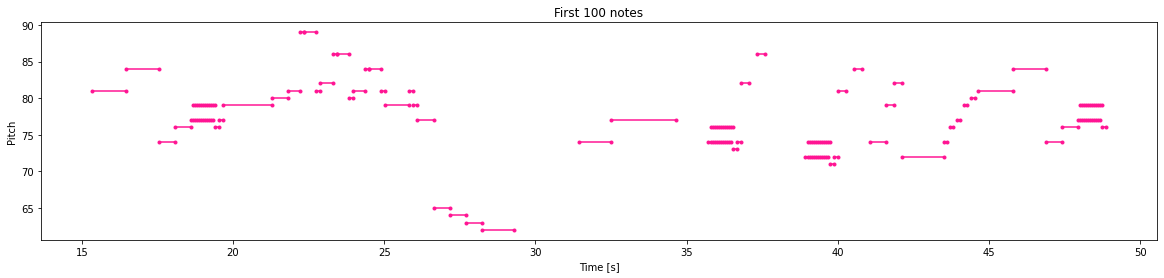

In [ ]:
plot_piano_roll(raw_notes, count=100)

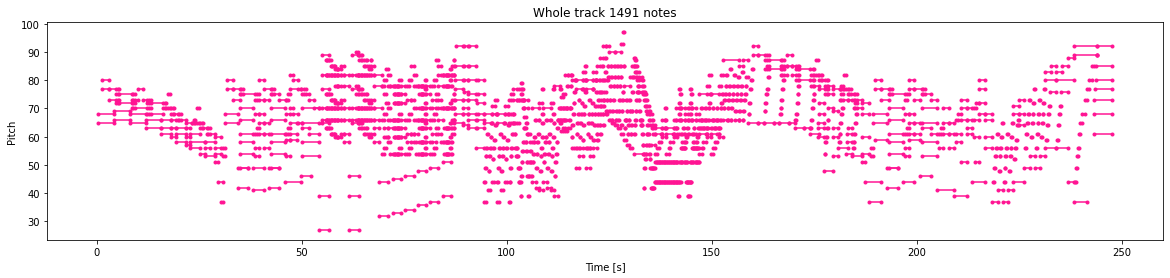

In [ ]:
plot_piano_roll(raw_notes)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5): #เอาค่าของ pitch step duration มาทำเป็นกราฟ 3 อัน
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

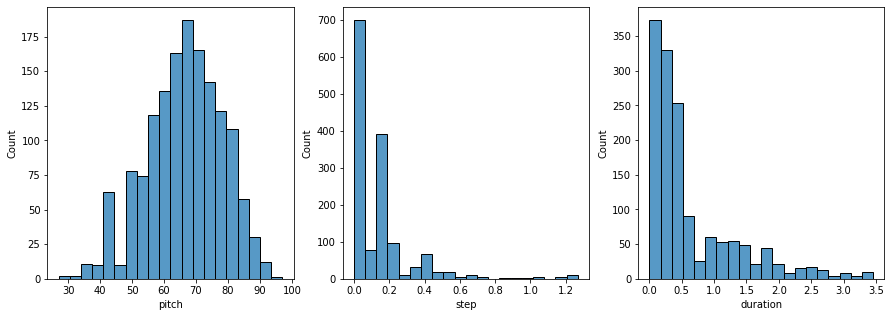

In [ ]:
plot_distributions(raw_notes)

In [943]:
def notes_to_midi(notes: pd.DataFrame,out_file: str, instrument_name: str,velocity: int = 100,  #note loudness
                  ) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
!mkdir -p /content/drive/Shareddrives/Workspace/LoFiMIDI/Myoutput #สร้าง Directory ที่เราต้องการ ตาม path ที่เรากำหนด
example_file = '/content/drive/Shareddrives/Workspace/LoFiMIDI/Myoutput/example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
#ลองเล่นไฟล์ MIDIที่สร้างขึ้นใหม่เพื่อดูว่าแตกต่างจากอันเดิมมั้ย
display_audio(example_pm)
#จากที่ฟังเปรียบเทียบ เสียงอันเก่าจะนุ่มฟุ้งกว่า ส่วนเสียงใหม่จะ clear กว่าอันเก่ามากยิ่งขึ้น

# Data Preparation

In [944]:
filenames = glob.glob('/content/drive/Shareddrives/Workspace/LoFiMIDI/Classical/Mozart/*.mid')
print('Number of files:', len(filenames))

Number of files: 21


In [970]:
#สร้างชุดข้อมูลการฝึก
# num_files = len(filenames)
num_files = 10
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [971]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 35550


In [972]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [973]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [974]:
def create_sequences(dataset: tf.data.Dataset,seq_length: int,vocab_size = 128,) -> tf.data.Dataset:
  seq_length = seq_length+1
  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)
  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x
  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
    return scale_pitch(inputs), labels
  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [975]:
seq_length = 50 #สามารถกำหนดค่า seq_length ใหม่ได้เพื่อทดลองว่า seq ไหนได้ผลดีที่สุด
vocab_size = 128 # ที่เป็นค่า 128 เพราะใช้แทน note ทั้งหมดที่รองรับใน pretty_midi
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [976]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (50, 3)
sequence elements (first 10): tf.Tensor(
[[0.390625  0.        0.423042 ]
 [0.578125  0.        0.423042 ]
 [0.515625  0.        0.423042 ]
 [0.5390625 0.        0.423042 ]
 [0.296875  0.        0.423042 ]
 [0.3515625 0.        0.423042 ]
 [0.6171875 0.846084  0.1116148]
 [0.515625  0.        0.405872 ]
 [0.484375  0.        0.405872 ]
 [0.609375  0.101468  0.1116148]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=78.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.10146799999999967>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.1116147999999999>}


# Defining Model

In [977]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [978]:
train_ds.element_spec

(TensorSpec(shape=(64, 50, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [979]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

# Training Model

In [980]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 50, 3)]      0           []                               
                                                                                                  
 lstm_34 (LSTM)                 (None, 128)          67584       ['input_35[0][0]']               
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_34[0][0]']                
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_34[0][0]']                
                                                                                           

In [981]:
losses = model.evaluate(train_ds, return_dict=True)
losses

554/554 [==============================] - 15s 5ms/step - loss: 5.8877 - duration_loss: 1.0011 - pitch_loss: 4.8604 - step_loss: 0.0262


{'duration_loss': 1.0010833740234375,
 'loss': 5.887669563293457,
 'pitch_loss': 4.860391139984131,
 'step_loss': 0.026197586208581924}

In [982]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [983]:
model.evaluate(train_ds, return_dict=True)

554/554 [==============================] - 3s 4ms/step - loss: 1.2703 - duration_loss: 1.0011 - pitch_loss: 4.8604 - step_loss: 0.0262


{'duration_loss': 1.0010833740234375,
 'loss': 1.2703008651733398,
 'pitch_loss': 4.860391139984131,
 'step_loss': 0.026197586208581924}

In [984]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/Shareddrives/Workspace/LoFiMIDI/2Model/model/Mozart/50-seq-2/{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [985]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
554/554 [==============================] - 6s 8ms/step - loss: 0.2690 - duration_loss: 0.0594 - pitch_loss: 3.6702 - step_loss: 0.0262
Epoch 2/50
554/554 [==============================] - 5s 9ms/step - loss: 0.2561 - duration_loss: 0.0531 - pitch_loss: 3.5672 - step_loss: 0.0247
Epoch 3/50
554/554 [==============================] - 4s 8ms/step - loss: 0.2517 - duration_loss: 0.0511 - pitch_loss: 3.5517 - step_loss: 0.0230
Epoch 4/50
554/554 [==============================] - 3s 6ms/step - loss: 0.2485 - duration_loss: 0.0496 - pitch_loss: 3.5351 - step_loss: 0.0222
Epoch 5/50
554/554 [==============================] - 3s 6ms/step - loss: 0.2454 - duration_loss: 0.0477 - pitch_loss: 3.5231 - step_loss: 0.0215
Epoch 6/50
554/554 [==============================] - 3s 6ms/step - loss: 0.2436 - duration_loss: 0.0465 - pitch_loss: 3.5146 - step_loss: 0.0213
Epoch 7/50
554/554 [==============================] - 3s 6ms/step - loss: 0.2392 - duration_loss: 0.0443 - pitch_loss: 3.486

In [986]:
model.save('/content/drive/Shareddrives/Workspace/LoFiMIDI/2Model/model for use/Mozart.h5')

In [994]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/Workspace/LoFiMIDI/Model/Mozart.h5', custom_objects={'mse_with_positive_pressure': mse_with_positive_pressure})

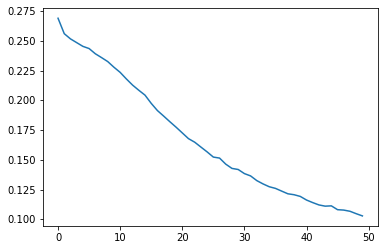

In [987]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Prediction & Evaluation

In [995]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [996]:
temperature = 2.0
num_predictions = 100 # จำนวน note batch ที่ต้องการ predict ออกมา

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [997]:
generated_notes.describe()

,pitch,step,duration,start,end
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,81.690000,0.230749,0.896157,9.659321,10.555478
std,8.896367,0.088364,0.098600,6.917907,6.967666
min,48.000000,0.000000,0.135895,0.087578,0.223473
25%,81.000000,0.156171,0.865230,3.861993,4.738284
50%,85.000000,0.290478,0.929830,8.022291,9.009768
75%,86.000000,0.300288,0.940040,15.440222,16.379644
max,89.000000,0.454487,1.125442,23.074908,24.010840


In [998]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,81,0.087578,0.135895,0.087578,0.223473
1,85,0.000000,0.879559,0.087578,0.967137
2,89,0.118651,0.801956,0.206229,1.008185
3,81,0.127657,0.805245,0.333886,1.139132
4,79,0.144879,0.790734,0.478765,1.269500
5,81,0.144987,0.779060,0.623752,1.402812
6,86,0.155889,0.786773,0.779641,1.566414
7,86,0.156265,0.795980,0.935906,1.731886
8,85,0.165792,0.794724,1.101698,1.896422
9,86,0.175664,0.781308,1.277362,2.058670


In [999]:
out_file = '/content/drive/Shareddrives/Workspace/LoFiMIDI/2Model/song/mozart-output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

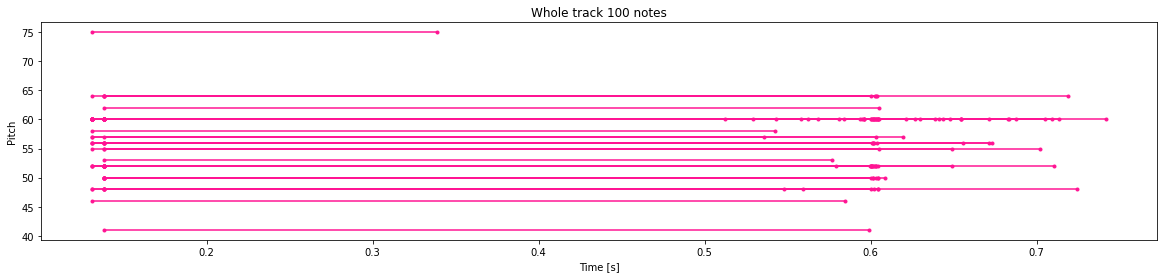

In [992]:
plot_piano_roll(generated_notes)

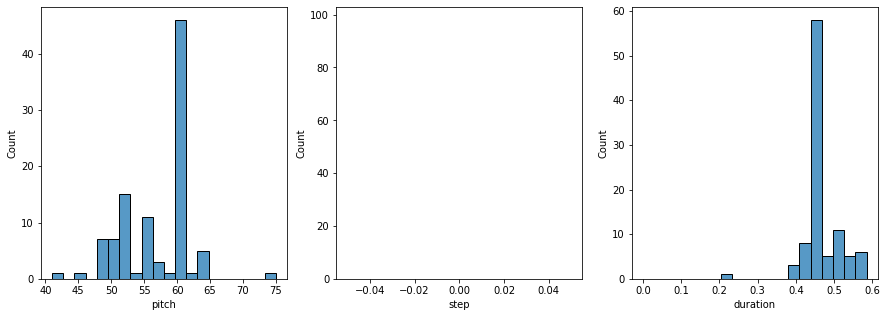

In [993]:
plot_distributions(generated_notes)